Load all per patient npz files from preprocessing notebook step 1;
train & evaluate a baseline logistic regression using handcrafted ECG window features + RR features under patient disjoint splits
Train/eval an RR aware 1D CNN fusuin model under LOGO 
Results;;;

We should get patient independent AF detection which generalizes across unseen patients

each window belongs to a patient
Leaveonegroupout() uses groups so all windows from one patient are held out together so a patient is truly "left out"


In [1]:
"""
Pipeline:
    Load per record npz's window datasets from step1 preprocess notebook
    Baseline: logistic regression on handcrafted ecg features + RR features
    MOdel: RR aware 1D CNN fusion 
    results;
"""



# Load npz's, baseline LR, CNN
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit, LeaveOneGroupOut
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, ConfusionMatrixDisplay

#feature extraction
from scipy.signal import welch
from scipy.integrate import trapezoid

import warnings
warnings.filterwarnings("ignore")

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


##PATHS::

NPZ_DIR = Path("../artifacts/afdb_npz")
RESULTS_DIR = Path("../results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

USE_LOGO_CV = True   #patient-independent evaluation
N_SPLITS = 5         # only used if USE_LOGO_CV=False,, which shouldnt be the case


#######
# Neural net config
#######
BATCH_SIZE = 1024     # 1024 can be too big depending on win_len + RAM/VRAM
EPOCHS = 4          #change this as needed ,, takes forever tho
LEARNING_RATE = 1e-4
EARLY_STOP_PATIENCE = 3



if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("Device:", DEVICE)
print("NPZ_DIR:", NPZ_DIR)
print("RESULTS_DIR:", RESULTS_DIR)


Device: mps
NPZ_DIR: ../artifacts/afdb_npz
RESULTS_DIR: ../results


In [2]:



# load dataset & check
def load_all_npz_files(npz_dir: Path):
    """
    load all perrecord NPZ files and concatenate into one dataset

    Expected arrays in each NPZ:
      X: (num_windows, win_len)  float32  (z-scored windows)
      y: (num_windows,)          int64    (0/1)
      rr_feat: (num_windows, 10) float32
      rr_valid: (num_windows,)   float32  (0/1)
      fs: scalar
      record: string

    Returns:
      X_all, y_all, rr_all, rr_valid_all, groups, meta_df
    """
    npz_files = sorted(npz_dir.glob("*.npz"))
    if not npz_files:
        raise RuntimeError(f"No .npz files found in {npz_dir}. Run preprocessing first.")

    rows = []  # per-file metadata rows
    X_list, y_list, rr_list, rv_list, g_list = [], [], [], [], []

    for path in npz_files:
        data = np.load(path, allow_pickle=True)

        X = data["X"]
        y = data["y"].astype(np.int64)

        rr_feat = data["rr_feat"] if "rr_feat" in data.files else np.zeros((len(y), 10), dtype=np.float32)
        rr_valid = data["rr_valid"] if "rr_valid" in data.files else np.zeros((len(y),), dtype=np.float32)

        fs = float(data["fs"]) if "fs" in data.files else np.nan
        record = str(data["record"]) if "record" in data.files else path.stem

        # Append to lists
        X_list.append(X)
        y_list.append(y)
        rr_list.append(rr_feat.astype(np.float32))
        rv_list.append(rr_valid.astype(np.float32))
        g_list.extend([record] * len(y))

        af_pct = 100.0 * float(y.mean()) if len(y) else 0.0

        rows.append({
            "npz": str(path),
            "record": record,
            "fs": fs,
            "windows": int(len(y)),
            "af_windows": int(y.sum()),
            "af_pct": af_pct,
            "win_len": int(X.shape[1]),
        })

        print(f"{record:6s} | fs={fs:6.1f} | windows={len(y):6d} | AF={int(y.sum()):6d} ({af_pct:6.2f}%)")

    X_all = np.vstack(X_list).astype(np.float32)
    y_all = np.concatenate(y_list).astype(np.int64)
    rr_all = np.vstack(rr_list).astype(np.float32)
    rr_valid_all = np.concatenate(rv_list).astype(np.float32)
    groups = np.asarray(g_list)

    meta = pd.DataFrame(rows)

    print("\n=== Dataset Totals ===")
    print("Windows:", len(y_all))
    print("AF%:", 100.0 * float(y_all.mean()))
    print("Records:", meta["record"].nunique())
    print("RR valid %:", 100.0 * float(rr_valid_all.mean()))


    ## CHECK DUPLICATES OF THE SAME RECORD
    # if you run preprcoess notebook more than once, youll have dupes. make sure the folder is empty
    # Strong duplicate check: more than 1 NPZ per record
    dup = meta.groupby("record").size()
    dup = dup[dup > 1]
    if len(dup) > 0:
        raise RuntimeError(
            "Multiple NPZ files per record detected (data leakage risk). "
            "Clear artifacts/afdb_npz or separate folders per setting.\n"
            f"{dup.sort_values(ascending=False).head(20)}"
        )


    ###check consistent window length (CNN assumes consistent win_len)
    winlens = meta["win_len"].unique()
    if len(winlens) != 1:
        raise RuntimeError(f"Inconsistent win_len across files: {winlens}. Regenerate with consistent WIN_SEC/fs.")

    return X_all, y_all, rr_all, rr_valid_all, groups, meta


X_all, y_all, rr_all, rr_valid_all, groups, meta = load_all_npz_files(NPZ_DIR)



04015  | fs= 250.0 | windows=  7363 | AF=    55 (  0.75%)
04043  | fs= 250.0 | windows=  7363 | AF=  1685 ( 22.88%)
04048  | fs= 250.0 | windows=  7363 | AF=    80 (  1.09%)
04126  | fs= 250.0 | windows=  7363 | AF=   284 (  3.86%)
04746  | fs= 250.0 | windows=  7363 | AF=  3917 ( 53.20%)
04908  | fs= 250.0 | windows=  7363 | AF=   670 (  9.10%)
04936  | fs= 250.0 | windows=  7363 | AF=  6035 ( 81.96%)
05091  | fs= 250.0 | windows=  7363 | AF=    25 (  0.34%)
05121  | fs= 250.0 | windows=  7363 | AF=  4706 ( 63.91%)
05261  | fs= 250.0 | windows=  7363 | AF=   109 (  1.48%)
06426  | fs= 250.0 | windows=  7363 | AF=  7089 ( 96.28%)
06453  | fs= 250.0 | windows=  6659 | AF=    81 (  1.22%)
06995  | fs= 250.0 | windows=  7363 | AF=  3476 ( 47.21%)
07162  | fs= 250.0 | windows=  7363 | AF=  7363 (100.00%)
07859  | fs= 250.0 | windows=  7363 | AF=  7363 (100.00%)
07879  | fs= 250.0 | windows=  7363 | AF=  4443 ( 60.34%)
07910  | fs= 250.0 | windows=  7363 | AF=  1274 ( 17.30%)
08215  | fs= 2

In [3]:
#baseline


"""
baseline ; logistic regression; just to check if everyhtng works

    Output: 16 features
      Time-domain (10):
        mean, std, min, max, ptp, rms, q25, q50, q75, iqr
      Frequency-domain (6):
        bandpower(0.5-5), bandpower(5-15), bandpower(15-40), total(0.5-40),
        ratio_mid, ratio_high

"""
def extract_features(X: np.ndarray, fs: float):

    N = X.shape[0]
    feats = np.zeros((N, 16), dtype=np.float32)

    print(f"Extracting features from {N:,} windows...;;;")

    for i in range(N):
        if i % 5000 == 0:
            print(f"  {i:,}/{N:,}")

        x = X[i]

        # TIME DOMAIN
        ## mean and std val are always 1 and 0 so theyre useless for af detection, could remove them and reduce features from 16 to 14
        mean_val = float(np.mean(x))
        std_val  = float(np.std(x))
        min_val  = float(np.min(x))
        max_val  = float(np.max(x))
        ptp_val  = float(np.ptp(x))
        rms_val  = float(np.sqrt(np.mean(x ** 2)))
        q25, q50, q75 = np.percentile(x, [25, 50, 75]).astype(np.float32)
        iqr_val  = float(q75 - q25)


        # #FREQUENCY DOMAIN VIA WELCH PSD
        # welch reduces variance vs raw fft;; stable on smaller windows
        freqs, psd = welch(x, fs=fs, nperseg=min(256, len(x)))

        def bandpower(f_low, f_high):
            idx = np.where((freqs >= f_low) & (freqs <= f_high))[0]
            if len(idx) == 0:
                return 0.0
            
            return float(trapezoid(psd[idx], freqs[idx]))

        bp_low   = bandpower(0.5, 5)
        bp_mid   = bandpower(5, 15)
        bp_high  = bandpower(15, 40)
        bp_total = bandpower(0.5, 40)

        ratio_mid  = bp_mid / (bp_total + 1e-8)
        ratio_high = bp_high / (bp_total + 1e-8)

        feats[i] = np.array([
            mean_val, std_val, min_val, max_val, ptp_val, rms_val,
            q25, q50, q75, iqr_val,
            bp_low, bp_mid, bp_high, bp_total, ratio_mid, ratio_high
        ], dtype=np.float32)

    print("Done!! Feature shape:", feats.shape)
    return feats


"""
Build baseline feature matrix:::
[wave16 | rr10 | rr_valid]
"""

# Use fs from metadata (all should match; if not, need per-record features or resample)
fs_used = float(meta["fs"].dropna().mode().iloc[0])  # most common fs
X_feat = extract_features(X_all, fs=fs_used)

# Combine waveform features + RR features + rr_valid flag
X_feat_full = np.hstack([
    X_feat.astype(np.float32),          # (N,16)
    rr_all.astype(np.float32),    # (N,10) prolly leave it unscaled for now
    rr_valid_all[:, None].astype(np.float32)  # (N, 1)
]).astype(np.float32)



Extracting features from 168,645 windows...;;;
  0/168,645
  5,000/168,645
  10,000/168,645
  15,000/168,645
  20,000/168,645
  25,000/168,645
  30,000/168,645
  35,000/168,645
  40,000/168,645
  45,000/168,645
  50,000/168,645
  55,000/168,645
  60,000/168,645
  65,000/168,645
  70,000/168,645
  75,000/168,645
  80,000/168,645
  85,000/168,645
  90,000/168,645
  95,000/168,645
  100,000/168,645
  105,000/168,645
  110,000/168,645
  115,000/168,645
  120,000/168,645
  125,000/168,645
  130,000/168,645
  135,000/168,645
  140,000/168,645
  145,000/168,645
  150,000/168,645
  155,000/168,645
  160,000/168,645
  165,000/168,645
Done!! Feature shape: (168645, 16)


In [4]:
# baseline logistic regression


"""
Evaluate the classifier;

    Sensitivity (recall on AF): how many AF windows you catch.
    Specificity: how often normal windows are correctly rejected.
    Precision: among predicted AF, how often it's truly AF.
    ROC-AUC: threshold-free separability (can look optimistic under imbalance).
    PR-AUC: more informative for imbalanced positives (often the key metric).

"""
def evaluate_model(y_true, y_pred, y_proba):
    cm = confusion_matrix(y_true, y_pred)

    # cm layout:
    # [[tn, fp],
    #  [fn, tp]]
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0  #recall for AF
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # recall for Normal
    precision   = tp / (tp + fp) if (tp + fp) > 0 else 0.0  # precision for AF


    # Only compute AUC if both classes exist in this fold
    roc_auc = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    pr_auc  = average_precision_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan

    return {
        "confusion_matrix": cm,
        "sensitivity": float(sensitivity),
        "specificity": float(specificity),
        "precision": float(precision),
        "roc_auc": float(roc_auc) if not np.isnan(roc_auc) else np.nan,
        "pr_auc": float(pr_auc) if not np.isnan(pr_auc) else np.nan,
    }


def train_baseline_model(X_feat, y, groups, use_logo=True):
    """
    Train logistic regression with record-disjoint splits.

    no leaks
    rr features are sometimes invalid, becuase of how its split; we fit the RR scaler mainly on valid RR to avoid corrupt scaling
    """
    print("\n" + "=" * 60)
    print("BASELINE: Logistic Regression")
    print("=" * 60)

    if use_logo:
        splitter = LeaveOneGroupOut()
        splits = splitter.split(X_feat, y, groups)
        print("Split: Leave-One-Group-Out    (records =", len(np.unique(groups)), ")")
    else:
        splitter = GroupShuffleSplit(n_splits=N_SPLITS, test_size=0.2, random_state=42)
        splits = splitter.split(X_feat, y, groups)
        print("Split: GroupShuffleSplit    (splits =", N_SPLITS, ")")

    results = []

    for fold, (train_idx, test_idx) in enumerate(splits, start=1):
       #X_train, X_test = X_feat[train_idx], X_feat[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        test_records = np.unique(groups[test_idx])

        # Standardize using TRAIN only (avoid leakage)
        # Feature layout: [wave16 | rr10 | rr_valid1]
        X_train, X_test = X_feat[train_idx], X_feat[test_idx]

        wave_train = X_train[:, :16]
        rr_train   = X_train[:, 16:26]
        rv_train   = X_train[:, 26:27]

        wave_test = X_test[:, :16]
        rr_test   = X_test[:, 16:26]
        rv_test   = X_test[:, 26:27]

        #Scale waveform features
        sc_wave = StandardScaler()
        wave_train_sc = sc_wave.fit_transform(wave_train)
        wave_test_sc  = sc_wave.transform(wave_test)

        #Scale RR features using TRAIN only, prioritize RR windows!!
        sc_rr = StandardScaler()
        valid_idx = np.where(rv_train[:, 0] > 0.5)[0]
        if len(valid_idx) >= 10:
            sc_rr.fit(rr_train[valid_idx])
        else:
            sc_rr.fit(rr_train)

        rr_train_sc = sc_rr.transform(rr_train)
        rr_test_sc  = sc_rr.transform(rr_test)

        # Zero invalid RR features
        rr_train_sc[rv_train[:, 0] <= 0.5] = 0.0
        rr_test_sc[rv_test[:, 0] <= 0.5]   = 0.0

        # Rebuild final matrices
        X_train_sc = np.hstack([wave_train_sc, rr_train_sc, rv_train])
        X_test_sc  = np.hstack([wave_test_sc,  rr_test_sc,  rv_test])


        # Balanced LR helps class imbalance
        clf = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
        clf.fit(X_train_sc, y_train)

        y_pred  = clf.predict(X_test_sc)
        y_proba = clf.predict_proba(X_test_sc)[:, 1]

        metrics = evaluate_model(y_test, y_pred, y_proba)

        print(f"\nFold {fold} | Test records: {test_records}")
        print(f"  Train windows: {len(train_idx):,} | Test windows: {len(test_idx):,}")
        print(f"  Sensitivity: {metrics['sensitivity']:.3f}")
        print(f"  Specificity: {metrics['specificity']:.3f}")
        print(f"  Precision:   {metrics['precision']:.3f}")
        print(f"  ROC-AUC:     {metrics['roc_auc']:.3f}")
        print(f"  PR-AUC:      {metrics['pr_auc']:.3f}")

        results.append(metrics)

    # Average metrics across folds (skip NaNs)
    avg = {}
    for k in ["sensitivity", "specificity", "precision", "roc_auc", "pr_auc"]:
        vals = [r[k] for r in results if not np.isnan(r[k])]
        avg[k] = float(np.mean(vals)) if vals else np.nan

    print("\n" + "-" * 60)
    print("AVERAGE (across folds):")
    for k, v in avg.items():
        print(f"  {k:12s}: {v:.3f}")

    return results, avg



baseline_results, baseline_avg = train_baseline_model(X_feat_full, y_all, groups, use_logo=USE_LOGO_CV)




BASELINE: Logistic Regression
Split: Leave-One-Group-Out    (records = 23 )

Fold 1 | Test records: ['04015']
  Train windows: 161,282 | Test windows: 7,363
  Sensitivity: 0.945
  Specificity: 0.938
  Precision:   0.103
  ROC-AUC:     0.960
  PR-AUC:      0.090

Fold 2 | Test records: ['04043']
  Train windows: 161,282 | Test windows: 7,363
  Sensitivity: 0.995
  Specificity: 0.026
  Precision:   0.232
  ROC-AUC:     0.912
  PR-AUC:      0.809

Fold 3 | Test records: ['04048']
  Train windows: 161,282 | Test windows: 7,363
  Sensitivity: 0.738
  Specificity: 0.941
  Precision:   0.121
  ROC-AUC:     0.970
  PR-AUC:      0.276

Fold 4 | Test records: ['04126']
  Train windows: 161,282 | Test windows: 7,363
  Sensitivity: 0.979
  Specificity: 0.924
  Precision:   0.341
  ROC-AUC:     0.985
  PR-AUC:      0.710

Fold 5 | Test records: ['04746']
  Train windows: 161,282 | Test windows: 7,363
  Sensitivity: 0.952
  Specificity: 0.990
  Precision:   0.990
  ROC-AUC:     0.997
  PR-AUC:     

In [5]:



"""
Dataloader for training:
returns in the format:

(
  ECG_window,
  RR_features,
  RR_valid_flag,
  label
)

converts the preprocessed arrays into a tuple 

"""
class ECGDataset(Dataset):
    """
    Dataset that returns:
      x: (1, win_len) float
      rr: (rr_dim,) float
      rr_valid: (1,) float
      y: scalar long
    """
    def __init__(self, X, rr, rr_valid, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)              # (N, 1, win_len)
        self.rr = torch.tensor(rr, dtype=torch.float32)                         # (N, rr_dim)
        self.rr_valid = torch.tensor(rr_valid, dtype=torch.float32).unsqueeze(1)# (N, 1)
        self.y = torch.tensor(y, dtype=torch.long)                              

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.rr[idx], self.rr_valid[idx], self.y[idx]



"""
CNN branch learns morphology from raw ecg window
mlp branch learns various rhythm dynamics from rr/hrv features

-join them then feed to classifier
[cnn_emb, rr_emb,rr_valid] ->classifier


"""
class ECGNetRR(nn.Module):
    """
    Fusion model:
      - CNN extracts morphology embedding
      - MLP extracts RR embedding
      - concatenate [cnn_emb, rr_emb, rr_valid] -> classifier

      we fuse becuase:
      AF is primarily rhythm irregularity (RR/HRV) but also affects morphology/context.
       Fusion tends to generalize better than either input alone.
    """
    def __init__(self, rr_dim=10):
        super().__init__()

        # CNN branch / cnn feature extractor
        self.conv1 = nn.Conv1d(1,   32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(32,  64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.conv4 = nn.Conv1d(128,256, kernel_size=5, padding=2)

        self.pool = nn.MaxPool1d(2)                 # downsample by factor of 2
        self.drop = nn.Dropout(0.5)                 # regularization so we can reduce ovverfitting per patient
        self.gap  = nn.AdaptiveAvgPool1d(1)         # global avg pool -> (B, 256, 1) ; fixed size embedding

        #RR/hrv branch (MLP)
        self.rr_fc1 = nn.Linear(rr_dim, 64)
        self.rr_fc2 = nn.Linear(64, 32)
        self.rr_drop = nn.Dropout(0.2)

        #Fusion classifier (+1 for rr_valid)
        self.fc = nn.Linear(256 + 32 + 1, 2)


#forward pass def
    def forward(self, x, rr, rr_valid):

        x = F.relu(self.conv1(x)); x = self.pool(x); x = self.drop(x)
        x = F.relu(self.conv2(x)); x = self.pool(x); x = self.drop(x)
        x = F.relu(self.conv3(x)); x = self.pool(x); x = self.drop(x)
        x = F.relu(self.conv4(x)); x = self.pool(x); x = self.drop(x)

        x = self.gap(x).squeeze(-1)  # (B, 256)

        # RR embedding
        rr = F.relu(self.rr_fc1(rr)); rr = self.rr_drop(rr)
        rr = F.relu(self.rr_fc2(rr))  # (B, 32)

        # Fusion
        z = torch.cat([x, rr, rr_valid], dim=1)  # (B, 289)
        out = self.fc(z)                         # logits (B, 2)

        return out


In [6]:
#train 


#a single epoch
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()

    total_loss = 0.0
    correct = 0
    total = 0

    for Xb, rrb, rvb, yb in loader:
        Xb = Xb.to(device)
        rrb = rrb.to(device)
        rvb = rvb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(Xb, rrb, rvb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item()) * len(yb)
        pred = torch.argmax(logits, dim=1)
        correct += int((pred == yb).sum().item())
        total += int(len(yb))

    return total_loss / total, correct / total


# eval each epoch: returns probabs so we can compute roc/pr
@torch.no_grad()
def eval_epoch(model, loader, criterion, device):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    probs_all = []
    y_all = []

    for Xb, rrb, rvb, yb in loader:
        Xb = Xb.to(device)
        rrb = rrb.to(device)
        rvb = rvb.to(device)
        yb = yb.to(device)

        logits = model(Xb, rrb, rvb)
        loss = criterion(logits, yb)

        total_loss += float(loss.item()) * len(yb)
        pred = torch.argmax(logits, dim=1)
        correct += int((pred == yb).sum().item())
        total += int(len(yb))

        p = F.softmax(logits, dim=1)[:, 1]  # P(AF)
        probs_all.append(p.cpu().numpy())
        y_all.append(yb.cpu().numpy())

    probs_all = np.concatenate(probs_all) if probs_all else np.array([])
    y_all = np.concatenate(y_all) if y_all else np.array([])

    return total_loss / total, correct / total, probs_all, y_all


In [7]:


"""
train cnn fusion model with patient disjoint logo cross val

Outer split is logo over groups; test patient is never used to train
validation split is done by selecting some training patients as val patients ; this keeps early stopping leakage free(remains disjount)
rr scaling is fit on train only
best model is the one with the lowest validation loss ; we save that
"""
def train_neural_network_logo(X_all, rr_all, rr_valid_all, y_all, groups):
    print("\n" + "=" * 60)
    print("NEURAL NET: LOGO CV (patient-independent)")
    print("=" * 60)

    splitter = LeaveOneGroupOut()
    results = []

    unique_groups = np.unique(groups)

    for fold, (train_idx, test_idx) in enumerate(splitter.split(X_all, y_all, groups), start=1):
       # if fold > MAX_FOLDS:
        #    break
        ##LOGO
        test_record = np.unique(groups[test_idx])
        assert len(test_record) == 1
        test_record = test_record[0]

        #split trainidx into train and val by patients
        train_groups = np.unique(groups[train_idx])
        rng = np.random.default_rng(42 + fold)
        rng.shuffle(train_groups)

        n_val = max(1, int(0.2 * len(train_groups)))
        val_groups = train_groups[:n_val]
        tr_groups  = train_groups[n_val:]

        tr_mask = np.isin(groups, tr_groups)
        va_mask = np.isin(groups, val_groups)
        te_mask = np.isin(groups, [test_record])

        X_train, y_train = X_all[tr_mask], y_all[tr_mask]
        rr_train, rv_train = rr_all[tr_mask], rr_valid_all[tr_mask]

        X_val, y_val = X_all[va_mask], y_all[va_mask]
        rr_val, rv_val = rr_all[va_mask], rr_valid_all[va_mask]

        X_test, y_test = X_all[te_mask], y_all[te_mask]
        rr_test, rv_test = rr_all[te_mask], rr_valid_all[te_mask]

        #RR scaling (TRAIN only) ----
        sc_rr = StandardScaler()
        valid_idx = np.where(rv_train > 0.5)[0]
        if len(valid_idx) >= 10:
            sc_rr.fit(rr_train[valid_idx])
        else:
            sc_rr.fit(rr_train)

        rr_train_sc = sc_rr.transform(rr_train).astype(np.float32)
        rr_val_sc   = sc_rr.transform(rr_val).astype(np.float32)
        rr_test_sc  = sc_rr.transform(rr_test).astype(np.float32)

        rr_train_sc[rv_train <= 0.5] = 0.0
        rr_val_sc[rv_val <= 0.5]     = 0.0
        rr_test_sc[rv_test <= 0.5]   = 0.0

        # loaders
        train_ds = ECGDataset(X_train, rr_train_sc, rv_train, y_train)
        val_ds   = ECGDataset(X_val,   rr_val_sc,   rv_val,   y_val)
        test_ds  = ECGDataset(X_test,  rr_test_sc,  rv_test,  y_test)

        # train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        # val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
        # test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)


        ## set num workers back to 0 if on mac and it freezes
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0)
        val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                                num_workers=0)
        test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                                num_workers=0)
        #test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                                #num_workers=0, pin_memory=True)


        # model
        model = ECGNetRR(rr_dim=rr_train_sc.shape[1]).to(DEVICE)

        # class weights (train only)
        n0 = float(np.sum(y_train == 0))
        n1 = float(np.sum(y_train == 1))
        if n1 > 0:
            w1 = n0 / (n1 + 1e-8)
            weights = torch.tensor([1.0, w1], dtype=torch.float32).to(DEVICE)
            criterion = nn.CrossEntropyLoss(weight=weights)
        else:
            criterion = nn.CrossEntropyLoss()

        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        best_val_loss = float("inf")
        best_state = None
        patience = 0

        for epoch in range(1, EPOCHS + 1):
            tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
            va_loss, va_acc, _, _ = eval_epoch(model, val_loader, criterion, DEVICE)

            print(
                f"Fold {fold:02d} | Epoch {epoch:02d}/{EPOCHS} | "
                f"train_loss {tr_loss:.4f} acc {tr_acc:.4f} | "
                f"val_loss {va_loss:.4f} acc {va_acc:.4f}"
            )



            if va_loss < best_val_loss - 1e-6:
                best_val_loss = va_loss
                patience = 0
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            else:
                patience += 1
                if patience >= EARLY_STOP_PATIENCE:
                    break

        if best_state is not None:
            model.load_state_dict(best_state)

            # !!!SAVE BEST MODEL FOR THIS FOLD !!!
            best_model_path = RESULTS_DIR / f"best_rrcnn_fold_{fold:02d}_{test_record}.pth"

            torch.save({
                "model_state": {k: v.detach().cpu() for k, v in model.state_dict().items()},
                "rr_dim": int(rr_train_sc.shape[1]),
                "test_record": str(test_record),
                "fold": int(fold),
                "best_val_loss": float(best_val_loss),
            }, best_model_path)



        _, test_acc, y_proba, y_true = eval_epoch(model, test_loader, criterion, DEVICE)
        y_pred = (y_proba >= 0.5).astype(int)
        metrics = evaluate_model(y_true, y_pred, y_proba)

        print(f"Fold {fold:02d}/{len(unique_groups)} | Test {test_record} | "
              f"ROC {metrics['roc_auc']:.3f} | PR {metrics['pr_auc']:.3f} | "
              f"Sens {metrics['sensitivity']:.3f} | Spec {metrics['specificity']:.3f}")

        metrics["test_record"] = test_record
        results.append(metrics)

    # macro average
    avg = {}
    for k in ["sensitivity", "specificity", "precision", "roc_auc", "pr_auc"]:
        vals = [r[k] for r in results if not np.isnan(r[k])]
        avg[k] = float(np.mean(vals)) if vals else np.nan

    print("\n" + "-" * 60)
    print("NN LOGO AVERAGE (macro over records):")
    for k, v in avg.items():
        print(f"  {k:12s}: {v:.3f}")

    return results, avg

nn_results, nn_avg = train_neural_network_logo(X_all, rr_all, rr_valid_all, y_all, groups)




NEURAL NET: LOGO CV (patient-independent)
Fold 01 | Epoch 01/4 | train_loss 0.6486 acc 0.7159 | val_loss 0.6733 acc 0.6060
Fold 01 | Epoch 02/4 | train_loss 0.5012 acc 0.8149 | val_loss 0.4474 acc 0.8934
Fold 01 | Epoch 03/4 | train_loss 0.3285 acc 0.9040 | val_loss 0.2837 acc 0.9301
Fold 01 | Epoch 04/4 | train_loss 0.2345 acc 0.9253 | val_loss 0.2486 acc 0.9278
Fold 01/23 | Test 04015 | ROC 0.985 | PR 0.243 | Sens 0.964 | Spec 0.928
Fold 02 | Epoch 01/4 | train_loss 0.6459 acc 0.7510 | val_loss 0.6000 acc 0.8396
Fold 02 | Epoch 02/4 | train_loss 0.5006 acc 0.8457 | val_loss 0.4643 acc 0.8302
Fold 02 | Epoch 03/4 | train_loss 0.3598 acc 0.8945 | val_loss 0.3270 acc 0.9193
Fold 02 | Epoch 04/4 | train_loss 0.2703 acc 0.9163 | val_loss 0.2472 acc 0.9392
Fold 02/23 | Test 04043 | ROC 0.977 | PR 0.841 | Sens 0.954 | Spec 0.953
Fold 03 | Epoch 01/4 | train_loss 0.6512 acc 0.6466 | val_loss 0.7299 acc 0.3502
Fold 03 | Epoch 02/4 | train_loss 0.4623 acc 0.8554 | val_loss 0.7851 acc 0.3795
F

In [8]:
# reuslts
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(f"{'Metric':<15} {'Baseline (LR)':<20} {'RR+CNN Fusion':<20}")
print("-" * 60)

for m in ["sensitivity", "specificity", "precision", "roc_auc", "pr_auc"]:
    print(f"{m:<15} {baseline_avg[m]:<20.3f} {nn_avg[m]:<20.3f}")


# Plot NN training curves
# plt.figure(figsize=(10, 4))
# plt.plot(nn_history["train_loss"], label="train_loss")
# plt.plot(nn_history["val_loss"], label="val_loss")
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.title("NN Loss")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig(RESULTS_DIR / "nn_loss.png", dpi=150)
# plt.show()

# plt.figure(figsize=(10, 4))
# plt.plot(nn_history["train_acc"], label="train_acc")
# plt.plot(nn_history["val_acc"], label="val_acc")
# plt.xlabel("epoch")
# plt.ylabel("accuracy")
# plt.title("NN Accuracy")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig(RESULTS_DIR / "nn_acc.png", dpi=150)
# plt.show()




MODEL COMPARISON
Metric          Baseline (LR)        RR+CNN Fusion       
------------------------------------------------------------
sensitivity     0.899                0.816               
specificity     0.779                0.822               
precision       0.663                0.651               
roc_auc         0.962                0.963               
pr_auc          0.744                0.723               


Confusion Matrix (Aggregate over LOGO folds):
[[88412 11434]
 [16133 52666]]


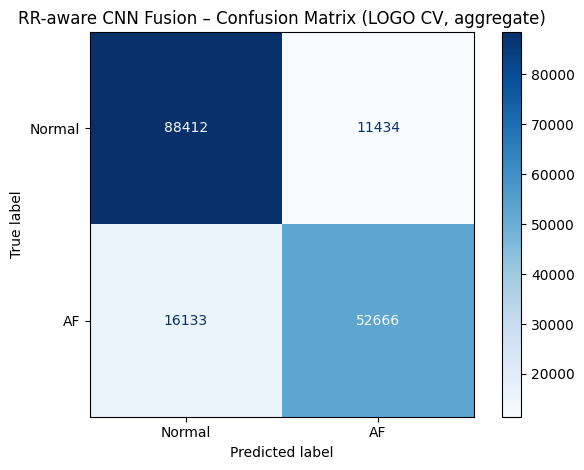

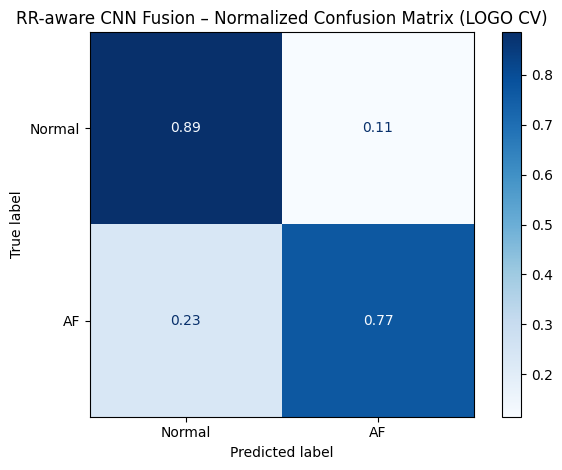

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Aggregate confusion matrices from all LOGO folds (no retraining needed)
cms = [r["confusion_matrix"] for r in nn_results if "confusion_matrix" in r and r["confusion_matrix"] is not None]
cm_total = np.sum(cms, axis=0)

print("Confusion Matrix (Aggregate over LOGO folds):")
print(cm_total)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_total,
    display_labels=["Normal", "AF"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("RR-aware CNN Fusion – Confusion Matrix (LOGO CV, aggregate)")
plt.tight_layout()
plt.show()

# Optional: normalized (row-wise)
cm_norm = cm_total.astype(np.float32) / (cm_total.sum(axis=1, keepdims=True) + 1e-8)
disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm_norm,
    display_labels=["Normal", "AF"]
)
disp2.plot(cmap="Blues", values_format=".2f")
plt.title("RR-aware CNN Fusion – Normalized Confusion Matrix (LOGO CV)")
plt.tight_layout()
plt.show()


Load all per patient npz files from preprocessing notebook step 1;
train & evaluate a baseline logistic regression using handcrafted ECG window features + RR features under patient disjoint splits
Train/eval an RR aware 1D CNN fusuin model under LOGO 
Results;;;

We should get patient independent AF detection which generalizes across unseen patients

each window belongs to a patient
Leaveonegroupout() uses groups so all windows from one patient are held out together so a patient is truly "left out"


In [13]:
"""
Pipeline:
    Load per record npz's window datasets from step1 preprocess notebook
    Baseline: logistic regression on handcrafted ecg features + RR features
    MOdel: RR aware 1D CNN fusion 
    results;
"""



# Load npz's, baseline LR, CNN
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit, LeaveOneGroupOut
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score

#feature extraction
from scipy.signal import welch
from scipy.integrate import trapezoid

import warnings
warnings.filterwarnings("ignore")

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


##PATHS::

NPZ_DIR = Path("../artifacts/afdb_npz")
RESULTS_DIR = Path("../results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

USE_LOGO_CV = True   #patient-independent evaluation
N_SPLITS = 5         # only used if USE_LOGO_CV=False,, which shouldnt be the case


#######
# Neural net config
#######
BATCH_SIZE = 1024     # 1024 can be too big depending on win_len + RAM/VRAM
EPOCHS = 15          #change this as needed ,, takes forever tho
LEARNING_RATE = 1e-4
EARLY_STOP_PATIENCE = 3



if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("Device:", DEVICE)
print("NPZ_DIR:", NPZ_DIR)
print("RESULTS_DIR:", RESULTS_DIR)


Device: mps
NPZ_DIR: ../artifacts/afdb_npz
RESULTS_DIR: ../results


In [ ]:



# load dataset & check
def load_all_npz_files(npz_dir: Path):
    """
    load all perrecord NPZ files and concatenate into one dataset

    Expected arrays in each NPZ:
      X: (num_windows, win_len)  float32  (z-scored windows)
      y: (num_windows,)          int64    (0/1)
      rr_feat: (num_windows, 10) float32
      rr_valid: (num_windows,)   float32  (0/1)
      fs: scalar
      record: string

    Returns:
      X_all, y_all, rr_all, rr_valid_all, groups, meta_df
    """
    npz_files = sorted(npz_dir.glob("*.npz"))
    if not npz_files:
        raise RuntimeError(f"No .npz files found in {npz_dir}. Run preprocessing first.")

    rows = []  # per-file metadata rows
    X_list, y_list, rr_list, rv_list, g_list = [], [], [], [], []

    for path in npz_files:
        data = np.load(path, allow_pickle=True)

        X = data["X"]
        y = data["y"].astype(np.int64)

        rr_feat = data["rr_feat"] if "rr_feat" in data.files else np.zeros((len(y), 10), dtype=np.float32)
        rr_valid = data["rr_valid"] if "rr_valid" in data.files else np.zeros((len(y),), dtype=np.float32)

        fs = float(data["fs"]) if "fs" in data.files else np.nan
        record = str(data["record"]) if "record" in data.files else path.stem

        # Append to lists
        X_list.append(X)
        y_list.append(y)
        rr_list.append(rr_feat.astype(np.float32))
        rv_list.append(rr_valid.astype(np.float32))
        g_list.extend([record] * len(y))

        af_pct = 100.0 * float(y.mean()) if len(y) else 0.0

        rows.append({
            "npz": str(path),
            "record": record,
            "fs": fs,
            "windows": int(len(y)),
            "af_windows": int(y.sum()),
            "af_pct": af_pct,
            "win_len": int(X.shape[1]),
        })

        print(f"{record:6s} | fs={fs:6.1f} | windows={len(y):6d} | AF={int(y.sum()):6d} ({af_pct:6.2f}%)")

    X_all = np.vstack(X_list).astype(np.float32)
    y_all = np.concatenate(y_list).astype(np.int64)
    rr_all = np.vstack(rr_list).astype(np.float32)
    rr_valid_all = np.concatenate(rv_list).astype(np.float32)
    groups = np.asarray(g_list)

    meta = pd.DataFrame(rows)

    print("\n=== Dataset Totals ===")
    print("Windows:", len(y_all))
    print("AF%:", 100.0 * float(y_all.mean()))
    print("Records:", meta["record"].nunique())
    print("RR valid %:", 100.0 * float(rr_valid_all.mean()))


    ## CHECK DUPLICATES OF THE SAME RECORD
    # if you run preprcoess notebook more than once, youll have dupes. make sure the folder is empty
    # Strong duplicate check: more than 1 NPZ per record
    dup = meta.groupby("record").size()
    dup = dup[dup > 1]
    if len(dup) > 0:
        raise RuntimeError(
            "Multiple NPZ files per record detected (data leakage risk). "
            "Clear artifacts/afdb_npz or separate folders per setting.\n"
            f"{dup.sort_values(ascending=False).head(20)}"
        )


    ###check consistent window length (CNN assumes consistent win_len)
    winlens = meta["win_len"].unique()
    if len(winlens) != 1:
        raise RuntimeError(f"Inconsistent win_len across files: {winlens}. Regenerate with consistent WIN_SEC/fs.")

    return X_all, y_all, rr_all, rr_valid_all, groups, meta


X_all, y_all, rr_all, rr_valid_all, groups, meta = load_all_npz_files(NPZ_DIR)



04015  | fs= 250.0 | windows=  7363 | AF=    55 (  0.75%)
04043  | fs= 250.0 | windows=  7363 | AF=  1685 ( 22.88%)
04048  | fs= 250.0 | windows=  7363 | AF=    80 (  1.09%)
04126  | fs= 250.0 | windows=  7363 | AF=   284 (  3.86%)
04746  | fs= 250.0 | windows=  7363 | AF=  3917 ( 53.20%)
04908  | fs= 250.0 | windows=  7363 | AF=   670 (  9.10%)
04936  | fs= 250.0 | windows=  7363 | AF=  6035 ( 81.96%)
05091  | fs= 250.0 | windows=  7363 | AF=    25 (  0.34%)
05121  | fs= 250.0 | windows=  7363 | AF=  4706 ( 63.91%)
05261  | fs= 250.0 | windows=  7363 | AF=   109 (  1.48%)
06426  | fs= 250.0 | windows=  7363 | AF=  7089 ( 96.28%)
06453  | fs= 250.0 | windows=  6659 | AF=    81 (  1.22%)
06995  | fs= 250.0 | windows=  7363 | AF=  3476 ( 47.21%)
07162  | fs= 250.0 | windows=  7363 | AF=  7363 (100.00%)
07859  | fs= 250.0 | windows=  7363 | AF=  7363 (100.00%)
07879  | fs= 250.0 | windows=  7363 | AF=  4443 ( 60.34%)
07910  | fs= 250.0 | windows=  7363 | AF=  1274 ( 17.30%)
08215  | fs= 2

In [ ]:
#baseline


"""
baseline ; logistic regression; just to check if everyhtng works

    Output: 16 features
      Time-domain (10):
        mean, std, min, max, ptp, rms, q25, q50, q75, iqr
      Frequency-domain (6):
        bandpower(0.5-5), bandpower(5-15), bandpower(15-40), total(0.5-40),
        ratio_mid, ratio_high

"""
def extract_features(X: np.ndarray, fs: float):

    N = X.shape[0]
    feats = np.zeros((N, 16), dtype=np.float32)

    print(f"Extracting features from {N:,} windows...;;;")

    for i in range(N):
        if i % 5000 == 0:
            print(f"  {i:,}/{N:,}")

        x = X[i]

        # TIME DOMAIN
        ## mean and std val are always 1 and 0 so theyre useless for af detection, could remove them and reduce features from 16 to 14
        mean_val = float(np.mean(x))
        std_val  = float(np.std(x))
        min_val  = float(np.min(x))
        max_val  = float(np.max(x))
        ptp_val  = float(np.ptp(x))
        rms_val  = float(np.sqrt(np.mean(x ** 2)))
        q25, q50, q75 = np.percentile(x, [25, 50, 75]).astype(np.float32)
        iqr_val  = float(q75 - q25)


        # #FREQUENCY DOMAIN VIA WELCH PSD
        # welch reduces variance vs raw fft;; stable on smaller windows
        freqs, psd = welch(x, fs=fs, nperseg=min(256, len(x)))

        def bandpower(f_low, f_high):
            idx = np.where((freqs >= f_low) & (freqs <= f_high))[0]
            if len(idx) == 0:
                return 0.0
            
            return float(trapezoid(psd[idx], freqs[idx]))

        bp_low   = bandpower(0.5, 5)
        bp_mid   = bandpower(5, 15)
        bp_high  = bandpower(15, 40)
        bp_total = bandpower(0.5, 40)

        ratio_mid  = bp_mid / (bp_total + 1e-8)
        ratio_high = bp_high / (bp_total + 1e-8)

        feats[i] = np.array([
            mean_val, std_val, min_val, max_val, ptp_val, rms_val,
            q25, q50, q75, iqr_val,
            bp_low, bp_mid, bp_high, bp_total, ratio_mid, ratio_high
        ], dtype=np.float32)

    print("Done!! Feature shape:", feats.shape)
    return feats


"""
Build baseline feature matrix:::
[wave16 | rr10 | rr_valid]
"""

# Use fs from metadata (all should match; if not, need per-record features or resample)
fs_used = float(meta["fs"].dropna().mode().iloc[0])  # most common fs
X_feat = extract_features(X_all, fs=fs_used)

# Combine waveform features + RR features + rr_valid flag
X_feat_full = np.hstack([
    X_feat.astype(np.float32),          # (N,16)
    rr_all.astype(np.float32),    # (N,10) prolly leave it unscaled for now
    rr_valid_all[:, None].astype(np.float32)  # (N, 1)
]).astype(np.float32)



Extracting features from 168,645 windows...;;;
  0/168,645
  5,000/168,645
  10,000/168,645
  15,000/168,645
  20,000/168,645
  25,000/168,645
  30,000/168,645
  35,000/168,645
  40,000/168,645
  45,000/168,645
  50,000/168,645
  55,000/168,645
  60,000/168,645
  65,000/168,645
  70,000/168,645
  75,000/168,645
  80,000/168,645
  85,000/168,645
  90,000/168,645
  95,000/168,645
  100,000/168,645
  105,000/168,645
  110,000/168,645
  115,000/168,645
  120,000/168,645
  125,000/168,645
  130,000/168,645
  135,000/168,645
  140,000/168,645
  145,000/168,645
  150,000/168,645
  155,000/168,645
  160,000/168,645
  165,000/168,645
Done!! Feature shape: (168645, 16)


In [ ]:
# baseline logistic regression


"""
Evaluate the classifier;

    Sensitivity (recall on AF): how many AF windows you catch.
    Specificity: how often normal windows are correctly rejected.
    Precision: among predicted AF, how often it's truly AF.
    ROC-AUC: threshold-free separability (can look optimistic under imbalance).
    PR-AUC: more informative for imbalanced positives (often the key metric).

"""
def evaluate_model(y_true, y_pred, y_proba):
    cm = confusion_matrix(y_true, y_pred)

    # cm layout:
    # [[tn, fp],
    #  [fn, tp]]
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0  #recall for AF
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # recall for Normal
    precision   = tp / (tp + fp) if (tp + fp) > 0 else 0.0  # precision for AF


    # Only compute AUC if both classes exist in this fold
    roc_auc = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan
    pr_auc  = average_precision_score(y_true, y_proba) if len(np.unique(y_true)) == 2 else np.nan

    return {
        "confusion_matrix": cm,
        "sensitivity": float(sensitivity),
        "specificity": float(specificity),
        "precision": float(precision),
        "roc_auc": float(roc_auc) if not np.isnan(roc_auc) else np.nan,
        "pr_auc": float(pr_auc) if not np.isnan(pr_auc) else np.nan,
    }


def train_baseline_model(X_feat, y, groups, use_logo=True):
    """
    Train logistic regression with record-disjoint splits.

    no leaks
    rr features are sometimes invalid, becuase of how its split; we fit the RR scaler mainly on valid RR to avoid corrupt scaling
    """
    print("\n" + "=" * 60)
    print("BASELINE: Logistic Regression")
    print("=" * 60)

    if use_logo:
        splitter = LeaveOneGroupOut()
        splits = splitter.split(X_feat, y, groups)
        print("Split: Leave-One-Group-Out    (records =", len(np.unique(groups)), ")")
    else:
        splitter = GroupShuffleSplit(n_splits=N_SPLITS, test_size=0.2, random_state=42)
        splits = splitter.split(X_feat, y, groups)
        print("Split: GroupShuffleSplit    (splits =", N_SPLITS, ")")

    results = []

    for fold, (train_idx, test_idx) in enumerate(splits, start=1):
       #X_train, X_test = X_feat[train_idx], X_feat[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        test_records = np.unique(groups[test_idx])

        # Standardize using TRAIN only (avoid leakage)
        # Feature layout: [wave16 | rr10 | rr_valid1]
        X_train, X_test = X_feat[train_idx], X_feat[test_idx]

        wave_train = X_train[:, :16]
        rr_train   = X_train[:, 16:26]
        rv_train   = X_train[:, 26:27]

        wave_test = X_test[:, :16]
        rr_test   = X_test[:, 16:26]
        rv_test   = X_test[:, 26:27]

        #Scale waveform features
        sc_wave = StandardScaler()
        wave_train_sc = sc_wave.fit_transform(wave_train)
        wave_test_sc  = sc_wave.transform(wave_test)

        #Scale RR features using TRAIN only, prioritize RR windows!!
        sc_rr = StandardScaler()
        valid_idx = np.where(rv_train[:, 0] > 0.5)[0]
        if len(valid_idx) >= 10:
            sc_rr.fit(rr_train[valid_idx])
        else:
            sc_rr.fit(rr_train)

        rr_train_sc = sc_rr.transform(rr_train)
        rr_test_sc  = sc_rr.transform(rr_test)

        # Zero invalid RR features
        rr_train_sc[rv_train[:, 0] <= 0.5] = 0.0
        rr_test_sc[rv_test[:, 0] <= 0.5]   = 0.0

        # Rebuild final matrices
        X_train_sc = np.hstack([wave_train_sc, rr_train_sc, rv_train])
        X_test_sc  = np.hstack([wave_test_sc,  rr_test_sc,  rv_test])


        # Balanced LR helps class imbalance
        clf = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
        clf.fit(X_train_sc, y_train)

        y_pred  = clf.predict(X_test_sc)
        y_proba = clf.predict_proba(X_test_sc)[:, 1]

        metrics = evaluate_model(y_test, y_pred, y_proba)

        print(f"\nFold {fold} | Test records: {test_records}")
        print(f"  Train windows: {len(train_idx):,} | Test windows: {len(test_idx):,}")
        print(f"  Sensitivity: {metrics['sensitivity']:.3f}")
        print(f"  Specificity: {metrics['specificity']:.3f}")
        print(f"  Precision:   {metrics['precision']:.3f}")
        print(f"  ROC-AUC:     {metrics['roc_auc']:.3f}")
        print(f"  PR-AUC:      {metrics['pr_auc']:.3f}")

        results.append(metrics)

    # Average metrics across folds (skip NaNs)
    avg = {}
    for k in ["sensitivity", "specificity", "precision", "roc_auc", "pr_auc"]:
        vals = [r[k] for r in results if not np.isnan(r[k])]
        avg[k] = float(np.mean(vals)) if vals else np.nan

    print("\n" + "-" * 60)
    print("AVERAGE (across folds):")
    for k, v in avg.items():
        print(f"  {k:12s}: {v:.3f}")

    return results, avg



baseline_results, baseline_avg = train_baseline_model(X_feat_full, y_all, groups, use_logo=USE_LOGO_CV)




BASELINE: Logistic Regression
Split: Leave-One-Group-Out    (records = 23 )

Fold 1 | Test records: ['04015']
  Train windows: 161,282 | Test windows: 7,363
  Sensitivity: 0.945
  Specificity: 0.938
  Precision:   0.103
  ROC-AUC:     0.960
  PR-AUC:      0.090

Fold 2 | Test records: ['04043']
  Train windows: 161,282 | Test windows: 7,363
  Sensitivity: 0.995
  Specificity: 0.026
  Precision:   0.232
  ROC-AUC:     0.912
  PR-AUC:      0.809

Fold 3 | Test records: ['04048']
  Train windows: 161,282 | Test windows: 7,363
  Sensitivity: 0.738
  Specificity: 0.941
  Precision:   0.121
  ROC-AUC:     0.970
  PR-AUC:      0.276

Fold 4 | Test records: ['04126']
  Train windows: 161,282 | Test windows: 7,363
  Sensitivity: 0.979
  Specificity: 0.924
  Precision:   0.341
  ROC-AUC:     0.985
  PR-AUC:      0.710

Fold 5 | Test records: ['04746']
  Train windows: 161,282 | Test windows: 7,363
  Sensitivity: 0.952
  Specificity: 0.990
  Precision:   0.990
  ROC-AUC:     0.997
  PR-AUC:     

In [ ]:



"""
Dataloader for training:
returns in the format:

(
  ECG_window,
  RR_features,
  RR_valid_flag,
  label
)

converts the preprocessed arrays into a tuple 

"""
class ECGDataset(Dataset):
    """
    Dataset that returns:
      x: (1, win_len) float
      rr: (rr_dim,) float
      rr_valid: (1,) float
      y: scalar long
    """
    def __init__(self, X, rr, rr_valid, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)              # (N, 1, win_len)
        self.rr = torch.tensor(rr, dtype=torch.float32)                         # (N, rr_dim)
        self.rr_valid = torch.tensor(rr_valid, dtype=torch.float32).unsqueeze(1)# (N, 1)
        self.y = torch.tensor(y, dtype=torch.long)                              

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.rr[idx], self.rr_valid[idx], self.y[idx]



"""
CNN branch learns morphology from raw ecg window
mlp branch learns various rhythm dynamics from rr/hrv features

-join them then feed to classifier
[cnn_emb, rr_emb,rr_valid] ->classifier


"""
class ECGNetRR(nn.Module):
    """
    Fusion model:
      - CNN extracts morphology embedding
      - MLP extracts RR embedding
      - concatenate [cnn_emb, rr_emb, rr_valid] -> classifier

      we fuse becuase:
      AF is primarily rhythm irregularity (RR/HRV) but also affects morphology/context.
       Fusion tends to generalize better than either input alone.
    """
    def __init__(self, rr_dim=10):
        super().__init__()

        # CNN branch / cnn feature extractor
        self.conv1 = nn.Conv1d(1,   32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(32,  64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.conv4 = nn.Conv1d(128,256, kernel_size=5, padding=2)

        self.pool = nn.MaxPool1d(2)                 # downsample by factor of 2
        self.drop = nn.Dropout(0.5)                 # regularization so we can reduce ovverfitting per patient
        self.gap  = nn.AdaptiveAvgPool1d(1)         # global avg pool -> (B, 256, 1) ; fixed size embedding

        #RR/hrv branch (MLP)
        self.rr_fc1 = nn.Linear(rr_dim, 64)
        self.rr_fc2 = nn.Linear(64, 32)
        self.rr_drop = nn.Dropout(0.2)

        #Fusion classifier (+1 for rr_valid)
        self.fc = nn.Linear(256 + 32 + 1, 2)


#forward pass def
    def forward(self, x, rr, rr_valid):

        x = F.relu(self.conv1(x)); x = self.pool(x); x = self.drop(x)
        x = F.relu(self.conv2(x)); x = self.pool(x); x = self.drop(x)
        x = F.relu(self.conv3(x)); x = self.pool(x); x = self.drop(x)
        x = F.relu(self.conv4(x)); x = self.pool(x); x = self.drop(x)

        x = self.gap(x).squeeze(-1)  # (B, 256)

        # RR embedding
        rr = F.relu(self.rr_fc1(rr)); rr = self.rr_drop(rr)
        rr = F.relu(self.rr_fc2(rr))  # (B, 32)

        # Fusion
        z = torch.cat([x, rr, rr_valid], dim=1)  # (B, 289)
        out = self.fc(z)                         # logits (B, 2)

        return out


In [ ]:
#train 


#a single epoch
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()

    total_loss = 0.0
    correct = 0
    total = 0

    for Xb, rrb, rvb, yb in loader:
        Xb = Xb.to(device)
        rrb = rrb.to(device)
        rvb = rvb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(Xb, rrb, rvb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item()) * len(yb)
        pred = torch.argmax(logits, dim=1)
        correct += int((pred == yb).sum().item())
        total += int(len(yb))

    return total_loss / total, correct / total


# eval each epoch: returns probabs so we can compute roc/pr
@torch.no_grad()
def eval_epoch(model, loader, criterion, device):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    probs_all = []
    y_all = []

    for Xb, rrb, rvb, yb in loader:
        Xb = Xb.to(device)
        rrb = rrb.to(device)
        rvb = rvb.to(device)
        yb = yb.to(device)

        logits = model(Xb, rrb, rvb)
        loss = criterion(logits, yb)

        total_loss += float(loss.item()) * len(yb)
        pred = torch.argmax(logits, dim=1)
        correct += int((pred == yb).sum().item())
        total += int(len(yb))

        p = F.softmax(logits, dim=1)[:, 1]  # P(AF)
        probs_all.append(p.cpu().numpy())
        y_all.append(yb.cpu().numpy())

    probs_all = np.concatenate(probs_all) if probs_all else np.array([])
    y_all = np.concatenate(y_all) if y_all else np.array([])

    return total_loss / total, correct / total, probs_all, y_all


In [ ]:


"""
train cnn fusion model with patient disjoint logo cross val

Outer split is logo over groups; test patient is never used to train
validation split is done by selecting some training patients as val patients ; this keeps early stopping leakage free(remains disjount)
rr scaling is fit on train only
best model is the one with the lowest validation loss ; we save that
"""
def train_neural_network_logo(X_all, rr_all, rr_valid_all, y_all, groups):
    print("\n" + "=" * 60)
    print("NEURAL NET: LOGO CV (patient-independent)")
    print("=" * 60)

    splitter = LeaveOneGroupOut()
    results = []

    unique_groups = np.unique(groups)

    for fold, (train_idx, test_idx) in enumerate(splitter.split(X_all, y_all, groups), start=1):
       # if fold > MAX_FOLDS:
        #    break
        ##LOGO
        test_record = np.unique(groups[test_idx])
        assert len(test_record) == 1
        test_record = test_record[0]

        #split trainidx into train and val by patients
        train_groups = np.unique(groups[train_idx])
        rng = np.random.default_rng(42 + fold)
        rng.shuffle(train_groups)

        n_val = max(1, int(0.2 * len(train_groups)))
        val_groups = train_groups[:n_val]
        tr_groups  = train_groups[n_val:]

        tr_mask = np.isin(groups, tr_groups)
        va_mask = np.isin(groups, val_groups)
        te_mask = np.isin(groups, [test_record])

        X_train, y_train = X_all[tr_mask], y_all[tr_mask]
        rr_train, rv_train = rr_all[tr_mask], rr_valid_all[tr_mask]

        X_val, y_val = X_all[va_mask], y_all[va_mask]
        rr_val, rv_val = rr_all[va_mask], rr_valid_all[va_mask]

        X_test, y_test = X_all[te_mask], y_all[te_mask]
        rr_test, rv_test = rr_all[te_mask], rr_valid_all[te_mask]

        #RR scaling (TRAIN only) ----
        sc_rr = StandardScaler()
        valid_idx = np.where(rv_train > 0.5)[0]
        if len(valid_idx) >= 10:
            sc_rr.fit(rr_train[valid_idx])
        else:
            sc_rr.fit(rr_train)

        rr_train_sc = sc_rr.transform(rr_train).astype(np.float32)
        rr_val_sc   = sc_rr.transform(rr_val).astype(np.float32)
        rr_test_sc  = sc_rr.transform(rr_test).astype(np.float32)

        rr_train_sc[rv_train <= 0.5] = 0.0
        rr_val_sc[rv_val <= 0.5]     = 0.0
        rr_test_sc[rv_test <= 0.5]   = 0.0

        # loaders
        train_ds = ECGDataset(X_train, rr_train_sc, rv_train, y_train)
        val_ds   = ECGDataset(X_val,   rr_val_sc,   rv_val,   y_val)
        test_ds  = ECGDataset(X_test,  rr_test_sc,  rv_test,  y_test)

        # train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        # val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
        # test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)


        ## set num workers back to 0 if on mac and it freezes
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0)
        val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                                num_workers=0)
        test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                                num_workers=0)
        #test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                                #num_workers=0, pin_memory=True)


        # model
        model = ECGNetRR(rr_dim=rr_train_sc.shape[1]).to(DEVICE)

        # class weights (train only)
        n0 = float(np.sum(y_train == 0))
        n1 = float(np.sum(y_train == 1))
        if n1 > 0:
            w1 = n0 / (n1 + 1e-8)
            weights = torch.tensor([1.0, w1], dtype=torch.float32).to(DEVICE)
            criterion = nn.CrossEntropyLoss(weight=weights)
        else:
            criterion = nn.CrossEntropyLoss()

        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        best_val_loss = float("inf")
        best_state = None
        patience = 0

        for epoch in range(1, EPOCHS + 1):
            tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
            va_loss, va_acc, _, _ = eval_epoch(model, val_loader, criterion, DEVICE)

            print(
                f"Fold {fold:02d} | Epoch {epoch:02d}/{EPOCHS} | "
                f"train_loss {tr_loss:.4f} acc {tr_acc:.4f} | "
                f"val_loss {va_loss:.4f} acc {va_acc:.4f}"
            )



            if va_loss < best_val_loss - 1e-6:
                best_val_loss = va_loss
                patience = 0
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            else:
                patience += 1
                if patience >= EARLY_STOP_PATIENCE:
                    break

        if best_state is not None:
            model.load_state_dict(best_state)

            # !!!SAVE BEST MODEL FOR THIS FOLD !!!
            best_model_path = RESULTS_DIR / f"best_rrcnn_fold_{fold:02d}_{test_record}.pth"

            torch.save({
                "model_state": {k: v.detach().cpu() for k, v in model.state_dict().items()},
                "rr_dim": int(rr_train_sc.shape[1]),
                "test_record": str(test_record),
                "fold": int(fold),
                "best_val_loss": float(best_val_loss),
                
                #added rr to be able to recreate scaling when using the model api
                "rr_mean":sc_rr.mean_,
                "rr_scale":sc_rr.scale_
            }, best_model_path)



        _, test_acc, y_proba, y_true = eval_epoch(model, test_loader, criterion, DEVICE)
        y_pred = (y_proba >= 0.5).astype(int)
        metrics = evaluate_model(y_true, y_pred, y_proba)

        print(f"Fold {fold:02d}/{len(unique_groups)} | Test {test_record} | "
              f"ROC {metrics['roc_auc']:.3f} | PR {metrics['pr_auc']:.3f} | "
              f"Sens {metrics['sensitivity']:.3f} | Spec {metrics['specificity']:.3f}")

        metrics["test_record"] = test_record
        results.append(metrics)

    # macro average
    avg = {}
    for k in ["sensitivity", "specificity", "precision", "roc_auc", "pr_auc"]:
        vals = [r[k] for r in results if not np.isnan(r[k])]
        avg[k] = float(np.mean(vals)) if vals else np.nan

    print("\n" + "-" * 60)
    print("NN LOGO AVERAGE (macro over records):")
    for k, v in avg.items():
        print(f"  {k:12s}: {v:.3f}")

    return results, avg

nn_results, nn_avg = train_neural_network_logo(X_all, rr_all, rr_valid_all, y_all, groups)




NEURAL NET: LOGO CV (patient-independent)
Fold 01 | Epoch 01/4 | train_loss 0.6588 acc 0.5849 | val_loss 0.7084 acc 0.4597
Fold 01 | Epoch 02/4 | train_loss 0.4924 acc 0.7935 | val_loss 0.5022 acc 0.8318
Fold 01 | Epoch 03/4 | train_loss 0.3234 acc 0.8903 | val_loss 0.3765 acc 0.8942
Fold 01 | Epoch 04/4 | train_loss 0.2341 acc 0.9133 | val_loss 0.4234 acc 0.8393
Fold 01/23 | Test 04015 | ROC 0.986 | PR 0.273 | Sens 0.982 | Spec 0.914
Fold 02 | Epoch 01/4 | train_loss 0.6548 acc 0.7194 | val_loss 0.5926 acc 0.7179
Fold 02 | Epoch 02/4 | train_loss 0.4842 acc 0.8737 | val_loss 0.4181 acc 0.7997
Fold 02 | Epoch 03/4 | train_loss 0.3021 acc 0.9027 | val_loss 0.3823 acc 0.7823
Fold 02 | Epoch 04/4 | train_loss 0.2236 acc 0.9217 | val_loss 0.3108 acc 0.8370
Fold 02/23 | Test 04043 | ROC 0.973 | PR 0.877 | Sens 0.982 | Spec 0.880
Fold 03 | Epoch 01/4 | train_loss 0.6539 acc 0.7524 | val_loss 0.6091 acc 0.7212
Fold 03 | Epoch 02/4 | train_loss 0.4711 acc 0.8546 | val_loss 0.6844 acc 0.4995
F

In [14]:
# reuslts
print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(f"{'Metric':<15} {'Baseline (LR)':<20} {'RR+CNN Fusion':<20}")
print("-" * 60)

for m in ["sensitivity", "specificity", "precision", "roc_auc", "pr_auc"]:
    print(f"{m:<15} {baseline_avg[m]:<20.3f} {nn_avg[m]:<20.3f}")


# Plot NN training curves
# plt.figure(figsize=(10, 4))
# plt.plot(nn_history["train_loss"], label="train_loss")
# plt.plot(nn_history["val_loss"], label="val_loss")
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.title("NN Loss")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig(RESULTS_DIR / "nn_loss.png", dpi=150)
# plt.show()

# plt.figure(figsize=(10, 4))
# plt.plot(nn_history["train_acc"], label="train_acc")
# plt.plot(nn_history["val_acc"], label="val_acc")
# plt.xlabel("epoch")
# plt.ylabel("accuracy")
# plt.title("NN Accuracy")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig(RESULTS_DIR / "nn_acc.png", dpi=150)
# plt.show()




MODEL COMPARISON
Metric          Baseline (LR)        RR+CNN Fusion       
------------------------------------------------------------
sensitivity     0.899                0.816               
specificity     0.779                0.822               
precision       0.663                0.651               
roc_auc         0.962                0.963               
pr_auc          0.744                0.723               


Confusion Matrix (Aggregate over LOGO folds):
[[88412 11434]
 [16133 52666]]


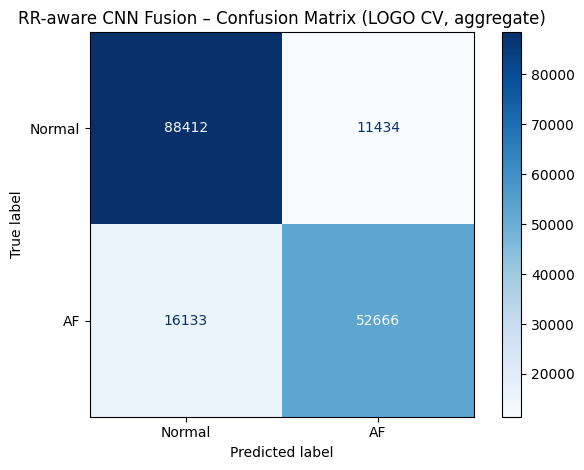

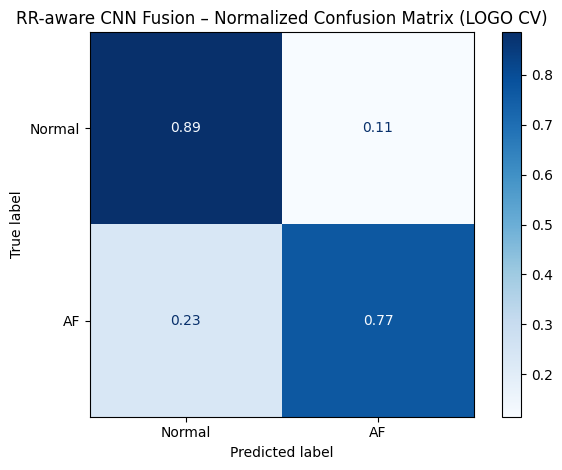

In [15]:


#aggregate confusion matrices from all LOGO folds (no retraining needed)
cms = [r["confusion_matrix"] for r in nn_results if "confusion_matrix" in r and r["confusion_matrix"] is not None]
cm_total = np.sum(cms, axis=0)



print("Confusion Matrix (Aggregate over LOGO folds):")
print(cm_total)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_total,
    display_labels=["Normal", "AF"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("RR-aware CNN Fusion – Confusion Matrix (LOGO CV, aggregate)")
plt.tight_layout()
#plt.
plt.show()
# normalized (row-wise)
cm_norm = cm_total.astype(np.float32) / (cm_total.sum(axis=1, keepdims=True) + 1e-8)
disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm_norm,
    display_labels=["Normal", "AF"]
)
disp2.plot(cmap="Blues", values_format=".2f")
plt.title("RR-aware CNN Fusion – Normalized Confusion Matrix (LOGO CV)")
plt.tight_layout()
plt.show()
